In [1]:
import os
import struct
import numpy as np

def read(dataset, path = "."):
    if dataset is "training":
        file_image = os.path.join(path, 'mnist_new-patterns-idx3-ubyte')
        file_label = os.path.join(path, 'mnist_new-labels-idx1-ubyte')
    elif dataset is "testing":
        file_image = os.path.join(path, 'mnist_new_test-patterns-idx3-ubyte')
        file_label = os.path.join(path, 'mnist_new_test-labels-idx1-ubyte')
    elif dataset is "testall":
        file_image = os.path.join(path, 'mnist_new_testall-patterns-idx3-ubyte')
    else:
        raise Exception("Invalid dataset name")

    with open(file_label, 'rb') as file:
        magic, num = struct.unpack(">II", file.read(8))
        label = np.fromfile(file, dtype=np.int8)

    with open(file_image, 'rb') as file:
        magic, num, rows, cols = struct.unpack(">IIII", file.read(16))
        image = np.fromfile(file, dtype=np.uint8).reshape(len(label), rows, cols)

    for i in range(len(label)):
        yield (image[i], label[i])

In [2]:
train_data = list(read("training"))
test_data = list(read("testing"))

X_train = np.array(list(zip(*train_data))[0])
y_train = np.array(list(zip(*train_data))[1])
X_test = np.array(list(zip(*test_data))[0])
y_test = np.array(list(zip(*test_data))[1])
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

C:\Users\Coder\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [94]:
from sklearn.base import BaseEstimator, ClassifierMixin
from time import time
import warnings
class CustomSVM(BaseEstimator, ClassifierMixin):  
    def __init__(self, max_iter=10000, C=1.0, eta=0.01, batch_size=1, tol=1e-6):
        self.max_iter = max_iter
        self.C = C
        self.eta = eta
        self.batch_size = batch_size
        self.tol = tol
        self.ws_ = None
        self.labels_ = None
        assert (type(self.max_iter) is int and self.max_iter > 0), "max_iter must be a positive integer"
        assert (type(self.C) is int or type(self.C) is float), "C parameter must be an integer or a float"      
        assert (type(self.eta) is int or type(self.eta) is float), "Eta parameter must be an integer or a float"      
        assert (type(self.batch_size) is int and self.batch_size > 0), "batch_size must be a positive integer"
        assert (type(self.tol) is int or type(self.tol) is float or tol is None), "Tolerance must be an integer or a float or None"
        
    def fit(self, X, y):
        if X.shape[0] < self.batch_size:
            self.batch_size = X.shape[0]
            warnings.warn("Batch size is bigger than the number of samples. It will be adjusted to the number of samples")
        self.ws_ = None
        self.labels_ = np.unique(y)
        for label in self.labels_:
            w_ = self.sub_fit(X, y, label)
            if self.ws_ is None:
                self.ws_ = np.append([label], w_)
            else:
                self.ws_ = np.vstack((self.ws_, np.append([label], w_)))
        return self
    
    def sub_fit(self, X, y, target_label):
        y = np.where(y == target_label, 1, -1)
        rgen = np.random.RandomState(int(time()))
        w_ = rgen.normal(loc=0.0, scale=1, size=1 + X.shape[1])
        for a in range(self.max_iter):
            step = self.eta * self.batch_grad(X, y, w_)
            w_ -= step
            if self.tol is not None and np.sum(step / w_) ** 2 < self.tol:
                break
        return w_
    
    def batch_grad(self, X, y, w_):
        idxs = np.random.choice(y.shape[0], self.batch_size, replace=False)
        mat = 1 - np.multiply(self.net_input(X[idxs], w_), y[idxs])
        pos_idxs = idxs[np.argwhere(mat >= 0).ravel()]
        gd_sumb = np.sum(-y[pos_idxs])
        gd_sumw = np.dot(X[pos_idxs].T, -y[pos_idxs]) + pos_idxs.size * w_[1:] / self.C
        return np.append(gd_sumb, gd_sumw) / self.batch_size
        
    def net_input(self, X, w_):
        return np.dot(X, w_[1:]) + w_[0]

    def predict(self, X):
        assert (self.ws_ is not None and self.labels_ is not None), "Estimator must be fit before prediction"
        return self.labels_[np.argmax(self.net_input(X, self.ws_[:, 1:].T), axis=1)]

    def score(self, X, y):
        return sum(self.predict(X) == y) / y.shape[0]

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [{'C': [0.01, 0.1, 1.0, 10.0], 'eta': [0.01, 0.05, 0.1, 0.25], 'max_iter': [5000, 7000, 10000, 20000]}]
gs = GridSearchCV(estimator=CustomSVM(), param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
gs = gs.fit(X_train_std, y_train)
print(gs.best_score_)
print(gs.best_params_)
print(gs.best_estimator_.score(X_test_std, y_test))
# {'C': 10.0, 'eta': 0.01, 'max_iter': 20000}
# This does not work on Jupyter notebook if OS is Windows

In [92]:
from time import time
def test_classifier(clf, X_train, y_train, X_test, y_test, C=10.0, eta=0.01, max_iter=50000, batch_size=1000, tol=None):
    inst = clf(C=C, eta=eta, max_iter=max_iter, batch_size=batch_size, tol=tol)
    start = time()
    inst.fit(X_train, y_train)
    end = time()
    train_accuracy = inst.score(X_train, y_train)
    test_accuracy = inst.score(X_test, y_test)
    print(clf.__name__)
    print("Elapsed Time : %d min %d sec" % ((end-start) // 60, (end-start) % 60))
    print("Train accuracy : %f" % train_accuracy)
    print("Test accuracy : %f \n" % test_accuracy)

In [6]:
test_classifier(CustomSVM, X_train_std, y_train, X_test_std, y_test)

Elapsed Time : 78 min 44 sec
Train accuracy : 0.871517
Test accuracy : 0.862000 


In [95]:
class MomentumSVM(CustomSVM):  
    def __init__(self, max_iter=10000, C=1.0, eta=0.01, batch_size=1, momentum=0.9, tol=1e-6):
        super().__init__(max_iter=max_iter, C=C, eta=eta, batch_size=batch_size, tol=tol)
        self.momentum = momentum
        assert (type(self.momentum) is int or type(self.momentum) is float), "Momentum term must be an integer or a float"
    
    def sub_fit(self, X, y, target_label):
        y = np.where(y == target_label, 1, -1)
        rgen = np.random.RandomState(int(time()))
        w_ = rgen.normal(loc=0.0, scale=1, size=1 + X.shape[1])
        before = np.zeros((X.shape[1] + 1, ))
        for a in range(self.max_iter):
            before = self.momentum * before + self.eta * self.batch_grad(X, y, w_)
            w_ -= before
            if self.tol is not None and np.sum(before / w_) ** 2 < self.tol:
                break
        return w_

In [8]:
test_classifier(MomentumSVM, X_train_std, y_train, X_test_std, y_test)

Elapsed Time : 77 min 44 sec
Train accuracy : 0.866183
Test accuracy : 0.858100 


In [96]:
class NAGSVM(CustomSVM):  
    def __init__(self, max_iter=10000, C=1.0, eta=0.01, batch_size=1, momentum=0.9, tol=1e-6):
        super().__init__(max_iter=max_iter, C=C, eta=eta, batch_size=batch_size, tol=tol)
        self.momentum = momentum
        assert (type(self.momentum) is int or type(self.momentum) is float), "Momentum term must be an integer or a float"
    
    def sub_fit(self, X, y, target_label):
        y = np.where(y == target_label, 1, -1)
        rgen = np.random.RandomState(int(time()))
        w_ = rgen.normal(loc=0.0, scale=1, size=1 + X.shape[1])
        before = np.zeros((X.shape[1] + 1, ))
        for a in range(self.max_iter):
            before = self.momentum * before + self.eta * self.batch_grad(X, y, w_)
            w_ -= before
            if self.tol is not None and np.sum(before / w_) ** 2 < self.tol:
                break
        return w_

In [10]:
test_classifier(NAGSVM, X_train_std, y_train, X_test_std, y_test)

Elapsed Time : 77 min 47 sec
Train accuracy : 0.866933
Test accuracy : 0.858200 


In [97]:
import math
class AdagradSVM(CustomSVM):  
    def __init__(self, max_iter=10000, C=1.0, eta=0.01, batch_size=1, epsilon=10**-6, tol=1e-6):
        super().__init__(max_iter=max_iter, C=C, eta=eta, batch_size=batch_size, tol=tol)
        self.epsilon = epsilon
        assert (type(self.epsilon) is int or type(self.epsilon) is float), "Epsilon must be an integer or a float"
    
    def sub_fit(self, X, y, target_label):
        y = np.where(y == target_label, 1, -1)
        rgen = np.random.RandomState(int(time()))
        w_ = rgen.normal(loc=0.0, scale=1, size=1 + X.shape[1])
        g_ = np.full((X.shape[1] + 1,), 1, dtype=float)
        for a in range(self.max_iter):
            grad = self.batch_grad(X, y, w_)
            g_ += grad ** 2
            step = self.eta / np.sqrt(g_ + self.epsilon) * grad
            w_ -= step
            if self.tol is not None and np.sum(step / w_) ** 2 < self.tol:
                break
        return w_

In [12]:
test_classifier(AdagradSVM, X_train_std, y_train, X_test_std, y_test)

Elapsed Time : 91 min 16 sec
Train accuracy : 0.823567
Test accuracy : 0.814800 


In [98]:
import math
class RMSPropSVM(CustomSVM):  
    def __init__(self, max_iter=10000, C=1.0, eta=0.01, batch_size=1, momentum=0.9, epsilon=10**-6, tol=1e-6):
        super().__init__(max_iter=max_iter, C=C, eta=eta, batch_size=batch_size, tol=tol)
        self.momentum = momentum
        self.epsilon = epsilon
        assert (type(self.momentum) is int or type(self.momentum) is float), "Momentum term must be an integer or a float"
        assert (type(self.epsilon) is int or type(self.epsilon) is float), "Epsilon must be an integer or a float"
    
    def sub_fit(self, X, y, target_label):
        y = np.where(y == target_label, 1, -1)
        rgen = np.random.RandomState(int(time()))
        w_ = rgen.normal(loc=0.0, scale=1, size=1 + X.shape[1])
        g_ = np.full((X.shape[1] + 1,), 1, dtype=float)
        for a in range(self.max_iter):
            grad = self.batch_grad(X, y, w_)
            g_ = self.momentum * g_ + (1 - self.momentum) * grad ** 2
            step = self.eta / np.sqrt(g_ + self.epsilon) * grad
            w_ -= step
            if self.tol is not None and np.sum(step / w_) ** 2 < self.tol:
                break
        return w_

In [14]:
test_classifier(RMSPropSVM, X_train_std, y_train, X_test_std, y_test)

Elapsed Time : 77 min 35 sec
Train accuracy : 0.867983
Test accuracy : 0.857400 


In [99]:
import math
class AdaDeltaSVM(CustomSVM):  
    def __init__(self, max_iter=10000, C=1.0, eta=0.01, batch_size=1, momentum=0.9, epsilon=10**-6, tol=1e-6):
        super().__init__(max_iter=max_iter, C=C, eta=eta, batch_size=batch_size, tol=tol)
        self.momentum = momentum
        self.epsilon = epsilon
        assert (type(self.momentum) is int or type(self.momentum) is float), "Momentum term must be an integer or a float"
        assert (type(self.epsilon) is int or type(self.epsilon) is float), "Epsilon must be an integer or a float"
    
    def sub_fit(self, X, y, target_label):
        y = np.where(y == target_label, 1, -1)
        rgen = np.random.RandomState(int(time()))
        w_ = rgen.normal(loc=0.0, scale=1, size=1 + X.shape[1])
        g_ = np.full((X.shape[1] + 1,), 1, dtype=float)
        s_ = np.full((X.shape[1] + 1,), self.eta**2, dtype=float)
        for a in range(self.max_iter):
            grad = self.batch_grad(X, y, w_)
            g_ = self.momentum * g_ + (1 - self.momentum) * grad ** 2
            delta = np.sqrt(s_ + self.epsilon) / np.sqrt(g_ + self.epsilon) * grad
            w_ -= delta
            s_ = self.momentum * s_ + (1 - self.momentum) * delta ** 2
            if self.tol is not None and np.sum(delta / w_) ** 2 < self.tol:
                break
        return w_

In [16]:
test_classifier(AdaDeltaSVM, X_train_std, y_train, X_test_std, y_test)

Elapsed Time : 78 min 18 sec
Train accuracy : 0.863233
Test accuracy : 0.854800 


In [100]:
class AdamSVM(CustomSVM):  
    def __init__(self, max_iter=10000, C=1.0, eta=0.01, batch_size=1, beta1=0.9, beta2=0.999, epsilon=10**-8, tol=1e-6):
        super().__init__(max_iter=max_iter, C=C, eta=eta, batch_size=batch_size, tol=tol)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        assert (type(self.beta1) is int or type(self.beta1) is float), "Beta1 must be an integer or a float"  
        assert (type(self.beta2) is int or type(self.beta2) is float), "Beta2 must be an integer or a float"   
        assert (type(self.epsilon) is int or type(self.epsilon) is float), "Epsilon must be an integer or a float"   

    
    def sub_fit(self, X, y, target_label):
        y = np.where(y == target_label, 1, -1)
        rgen = np.random.RandomState(int(time()))
        w_ = rgen.normal(loc=0.0, scale=1, size=1 + X.shape[1])
        m_ = np.zeros((X.shape[1] + 1,), dtype=float)
        v_ = np.zeros((X.shape[1] + 1,), dtype=float)
        for t in range(self.max_iter):
            grad = self.batch_grad(X, y, w_)
            m_ = self.beta1 * m_ + (1 - self.beta1) * grad
            v_ = self.beta2 * v_ + (1 - self.beta2) * grad ** 2
            step = self.eta * m_ / (1 - self.beta1**(t+1)) / np.sqrt(v_ / (1 - self.beta2**(t+1)) + self.epsilon)
            w_ -= step
            if self.tol is not None and np.sum(step / w_) ** 2 < self.tol:
                break
        return w_


In [18]:
test_classifier(AdamSVM, X_train_std, y_train, X_test_std, y_test)

Elapsed Time : 78 min 40 sec
Train accuracy : 0.854683
Test accuracy : 0.845200 


In [12]:
test_classifier(CustomSVM, X_train_std, y_train, X_test_std, y_test, max_iter=15000, batch_size=300)
test_classifier(MomentumSVM, X_train_std, y_train, X_test_std, y_test, max_iter=15000, batch_size=300)
test_classifier(NAGSVM, X_train_std, y_train, X_test_std, y_test, max_iter=15000, batch_size=300)
test_classifier(AdagradSVM, X_train_std, y_train, X_test_std, y_test, max_iter=15000, batch_size=300)
test_classifier(RMSPropSVM, X_train_std, y_train, X_test_std, y_test, max_iter=15000, batch_size=300)
test_classifier(AdaDeltaSVM, X_train_std, y_train, X_test_std, y_test, max_iter=15000, batch_size=300)
test_classifier(AdamSVM, X_train_std, y_train, X_test_std, y_test, max_iter=15000, batch_size=300)

CustomSVM
Elapsed Time : 10 min 11 sec
Train accuracy : 0.859683
Test accuracy : 0.851800 

MomentumSVM
Elapsed Time : 9 min 54 sec
Train accuracy : 0.861450
Test accuracy : 0.854500 

NAGSVM
Elapsed Time : 9 min 57 sec
Train accuracy : 0.863717
Test accuracy : 0.857100 

AdagradSVM
Elapsed Time : 12 min 11 sec
Train accuracy : 0.595000
Test accuracy : 0.596700 

RMSPropSVM
Elapsed Time : 10 min 0 sec
Train accuracy : 0.866583
Test accuracy : 0.857500 

AdaDeltaSVM
Elapsed Time : 10 min 8 sec
Train accuracy : 0.862000
Test accuracy : 0.855800 

AdamSVM
Elapsed Time : 10 min 11 sec
Train accuracy : 0.837817
Test accuracy : 0.832100 



In [127]:
class HaarTransformer:
    mask1 = np.array([[0, 0, 0, 0, 1, 1, 1, 1],
                      [0, 0, 0, 0, 1, 1, 1, 1],
                      [0, 0, 0, 0, 1, 1, 1, 1],
                      [0, 0, 0, 0, 1, 1, 1, 1],
                      [0, 0, 0, 0, 1, 1, 1, 1],
                      [0, 0, 0, 0, 1, 1, 1, 1],
                      [0, 0, 0, 0, 1, 1, 1, 1],
                      [0, 0, 0, 0, 1, 1, 1, 1]])
    mask2 = np.array([[0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1]])
    mask3 = np.array([[0, 0, 0, 1, 1, 0, 0, 0],
                      [0, 0, 0, 1, 1, 0, 0, 0],
                      [0, 0, 0, 1, 1, 0, 0, 0],
                      [0, 0, 0, 1, 1, 0, 0, 0],
                      [0, 0, 0, 1, 1, 0, 0, 0],
                      [0, 0, 0, 1, 1, 0, 0, 0],
                      [0, 0, 0, 1, 1, 0, 0, 0],
                      [0, 0, 0, 1, 1, 0, 0, 0]])
    mask4 = np.array([[0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0]])
    mask5 = np.array([[0, 0, 0, 0, 1, 1, 1, 1],
                      [0, 0, 0, 0, 1, 1, 1, 1],
                      [0, 0, 0, 0, 1, 1, 1, 1],
                      [0, 0, 0, 0, 1, 1, 1, 1],
                      [1, 1, 1, 1, 0, 0, 0, 0],
                      [1, 1, 1, 1, 0, 0, 0, 0],
                      [1, 1, 1, 1, 0, 0, 0, 0],
                      [1, 1, 1, 1, 0, 0, 0, 0]])
    masks = (mask1, mask2, mask3, mask4, mask5)
    
    @staticmethod
    def apply_mask(mat, mask):
        white = sum(mat[mask==1]) / mask[mask==1].size
        mask = np.where(mask == 1, 0, 1)
        black = sum(mat[mask==1]) / mask[mask==1].size
        return abs(white - black)
    
    @staticmethod
    def transform(X):
        X = X.reshape(X.shape[0], 28, 28)
        result = [[HaarTransformer.apply_mask(X[i][row:row+8, col:col+8], mask) \
                  for mask in HaarTransformer.masks for row in range(0, 21, 4) for col in range(0, 21, 4)] for i in range(X.shape[0])] 
        return np.array(result)

In [ ]:
X_train_haar = HaarTransformer.transform(X_train)
X_test_haar = HaarTransformer.transform(X_test)
print(X_train_haar.shape)
scaler = StandardScaler()
scaler.fit(X_train_haar)
X_train_haar_std = scaler.transform(X_train_haar)
X_test_haar_std = scaler.transform(X_test_haar)

In [19]:
test_classifier(CustomSVM, X_train_haar_std, y_train, X_test_haar_std, y_test, max_iter=15000, batch_size=300)
test_classifier(MomentumSVM, X_train_haar_std, y_train, X_test_haar_std, y_test, max_iter=15000, batch_size=300)
test_classifier(NAGSVM, X_train_haar_std, y_train, X_test_haar_std, y_test, max_iter=15000, batch_size=300)
test_classifier(AdagradSVM, X_train_haar_std, y_train, X_test_haar_std, y_test, max_iter=15000, batch_size=300)
test_classifier(RMSPropSVM, X_train_haar_std, y_train, X_test_haar_std, y_test, max_iter=15000, batch_size=300)
test_classifier(AdaDeltaSVM, X_train_haar_std, y_train, X_test_haar_std, y_test, max_iter=15000, batch_size=300)
test_classifier(AdamSVM, X_train_haar_std, y_train, X_test_haar_std, y_test, max_iter=15000, batch_size=300)

CustomSVM
Elapsed Time : 9 min 41 sec
Train accuracy : 0.926083
Test accuracy : 0.925100 

MomentumSVM
Elapsed Time : 9 min 45 sec
Train accuracy : 0.928867
Test accuracy : 0.930600 

NAGSVM
Elapsed Time : 9 min 27 sec
Train accuracy : 0.929900
Test accuracy : 0.931500 

AdagradSVM
Elapsed Time : 11 min 1 sec
Train accuracy : 0.779750
Test accuracy : 0.789500 

RMSPropSVM
Elapsed Time : 10 min 0 sec
Train accuracy : 0.930550
Test accuracy : 0.931600 

AdaDeltaSVM
Elapsed Time : 9 min 36 sec
Train accuracy : 0.927983
Test accuracy : 0.929500 

AdamSVM
Elapsed Time : 9 min 34 sec
Train accuracy : 0.921817
Test accuracy : 0.923200 



In [ ]:
from sklearn.linear_model import LinearRegression
class LinearApproximator:
    @staticmethod
    def regression(mat):
        cords = np.argwhere(mat != 0)
        if len(cords) == 0:
            return 0, 0
        xs = cords[:, 0].reshape(1, -1).T
        ys = cords[:, 0]
        reg = LinearRegression()
        reg.fit(xs, ys)
        return reg.coef_, reg.intercept_
    
    @staticmethod
    def transform(X):
        X = X.reshape(X.shape[0], 28, 28)
        result = [[t for row in range(0, 21, 4) for col in range(0, 21, 4) \
                  for t in LinearApproximator.regression(X[i][row:row+8, col:col+8])] for i in range(X.shape[0])] 
        return np.array(result)

In [ ]:
X_train_reg = LinearApproximator.transform(X_train)
X_test_reg = LinearApproximator.transform(X_test)
print(X_train_reg.shape)

In [28]:
X_train_merge = np.hstack((X_train_haar, X_train_reg))
X_test_merge = np.hstack((X_test_haar, X_test_reg))
scaler = StandardScaler()
scaler.fit(X_train_merge)
X_train_merge_std = scaler.transform(X_train_merge)
X_test_merge_std = scaler.transform(X_test_merge)
print(X_train_merge_std.shape)

C:\Users\Coder\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(60000, 252)


In [29]:
test_classifier(CustomSVM, X_train_merge_std, y_train, X_test_merge_std, y_test, max_iter=15000, batch_size=300)
test_classifier(MomentumSVM, X_train_merge_std, y_train, X_test_merge_std, y_test, max_iter=15000, batch_size=300)
test_classifier(NAGSVM, X_train_merge_std, y_train, X_test_merge_std, y_test, max_iter=15000, batch_size=300)
test_classifier(AdagradSVM, X_train_merge_std, y_train, X_test_merge_std, y_test, max_iter=15000, batch_size=300)
test_classifier(RMSPropSVM, X_train_merge_std, y_train, X_test_merge_std, y_test, max_iter=15000, batch_size=300)
test_classifier(AdaDeltaSVM, X_train_merge_std, y_train, X_test_merge_std, y_test, max_iter=15000, batch_size=300)
test_classifier(AdamSVM, X_train_merge_std, y_train, X_test_merge_std, y_test, max_iter=15000, batch_size=300)

CustomSVM
Elapsed Time : 9 min 33 sec
Train accuracy : 0.930500
Test accuracy : 0.928200 

MomentumSVM
Elapsed Time : 9 min 23 sec
Train accuracy : 0.936167
Test accuracy : 0.935300 

NAGSVM
Elapsed Time : 9 min 21 sec
Train accuracy : 0.935000
Test accuracy : 0.934800 

AdagradSVM
Elapsed Time : 10 min 56 sec
Train accuracy : 0.724067
Test accuracy : 0.726700 

RMSPropSVM
Elapsed Time : 9 min 16 sec
Train accuracy : 0.936100
Test accuracy : 0.935100 

AdaDeltaSVM
Elapsed Time : 9 min 27 sec
Train accuracy : 0.933950
Test accuracy : 0.935400 

AdamSVM
Elapsed Time : 9 min 46 sec
Train accuracy : 0.928100
Test accuracy : 0.926200 



In [13]:
class Centralizer:
    @staticmethod
    def v_centralize(mat):
        h_sum = mat.sum(axis=1)
        nonzero_rows = np.argwhere(h_sum != 0).ravel()
        top_padding = nonzero_rows[0] 
        bottom_padding = 28 - nonzero_rows[nonzero_rows.size-1]
        if abs(top_padding - bottom_padding) > 1:
            move = (top_padding + bottom_padding) // 2 - top_padding
            return np.roll(mat, move, axis=0)
        else:
            return mat
        
    @staticmethod
    def h_centralize(mat):
        v_sum = mat.sum(axis=0)
        nonzero_cols = np.argwhere(v_sum != 0).ravel()
        left_padding = nonzero_cols[0] 
        right_padding = 28 - nonzero_cols[nonzero_cols.size-1]
        if abs(left_padding - right_padding) > 1:
            move = (left_padding + right_padding) // 2 - left_padding
            return np.roll(mat, move, axis=1)
        else:
            return mat
    @staticmethod
    def centralize(mat):
        return Centralizer.h_centralize(Centralizer.v_centralize(mat))
        
    @staticmethod
    def transform(X):
        X = X.reshape(X.shape[0], 28, 28)
        return np.array([Centralizer.centralize(mat) for mat in X]).reshape(X.shape[0], 784)

In [38]:
X_train_centralized = Centralizer.transform(X_train)

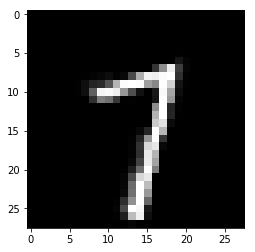

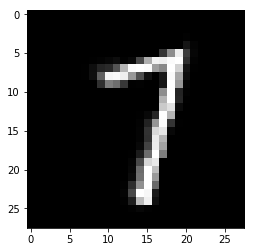

In [65]:
import matplotlib.pyplot as plt
plt.imshow(X_train[42].reshape(28, 28), cmap='gray')
plt.show()
plt.imshow(X_train_centralized[42].reshape(28, 28), cmap='gray')
plt.show()

In [ ]:
from time import time
start = time()
X_train_centralized = Centralizer.transform(X_train)
X_test_centralized = Centralizer.transform(X_test)
end = time()
print("Elapsed Time for centralization : %d min %d sec" % ((end-start) // 60, (end-start) % 60))
start = time()
X_train_haar = HaarTransformer.transform(X_train_centralized)
X_test_haar = HaarTransformer.transform(X_test_centralized)
end = time()
print("Elapsed Time for Haar transformation : %d min %d sec" % ((end-start) // 60, (end-start) % 60))
start = time()
X_train_reg = LinearApproximator.transform(X_train_centralized)
X_test_reg = LinearApproximator.transform(X_test_centralized)
end = time()
print("Elapsed Time for linear approximation : %d min %d sec" % ((end-start) // 60, (end-start) % 60))
X_train_merge = np.hstack((X_train_haar, X_train_reg))
X_test_merge = np.hstack((X_test_haar, X_test_reg))

In [15]:
import math
def rbf_features(X, gamma=0.22):
    return [t for idx in range(X.size) if (idx+1) % 6 != 0 and 36 - idx % 36 > 6 \
            for t in (math.exp(-gamma * (X[idx] - X[idx+1]) ** 2), \
                      math.exp(-gamma * (X[idx] - X[idx+6]) ** 2), \
                      math.exp(-gamma * (X[idx] - X[idx+7]) ** 2))]

In [16]:
from sklearn.preprocessing import StandardScaler
start = time()
rbfs_train = np.array([rbf_features(X) for X in X_train_merge])
rbfs_test = np.array([rbf_features(X) for X in X_test_merge])
end = time()
print("Elapsed Time for adding rbf features : %d min %d sec" % ((end-start) // 60, (end-start) % 60))
X_train_final = np.hstack((X_train_merge, rbfs_train))
X_test_final = np.hstack((X_test_merge, rbfs_test))
print(X_train_final.shape)
scaler = StandardScaler()
scaler.fit(X_train_final)
X_train_final_std = scaler.transform(X_train_final)
X_test_final_std = scaler.transform(X_test_final)

Elapsed Time for adding rbf features : 0 min 49 sec
(60000, 777)


In [97]:
test_classifier(CustomSVM, X_train_final_std, y_train, X_test_final_std, y_test, max_iter=15000, batch_size=300)
test_classifier(MomentumSVM, X_train_final_std, y_train, X_test_final_std, y_test, max_iter=15000, batch_size=300)
test_classifier(NAGSVM, X_train_final_std, y_train, X_test_final_std, y_test, max_iter=15000, batch_size=300)
test_classifier(AdagradSVM, X_train_final_std, y_train, X_test_final_std, y_test, max_iter=15000, batch_size=300)
test_classifier(RMSPropSVM, X_train_final_std, y_train, X_test_final_std, y_test, max_iter=15000, batch_size=300)
test_classifier(AdaDeltaSVM, X_train_final_std, y_train, X_test_final_std, y_test, max_iter=15000, batch_size=300)
test_classifier(AdamSVM, X_train_final_std, y_train, X_test_final_std, y_test, max_iter=15000, batch_size=300)

CustomSVM
Elapsed Time : 9 min 36 sec
Train accuracy : 0.940150
Test accuracy : 0.933300 

MomentumSVM
Elapsed Time : 9 min 13 sec
Train accuracy : 0.954583
Test accuracy : 0.946400 

NAGSVM
Elapsed Time : 9 min 16 sec
Train accuracy : 0.955683
Test accuracy : 0.947300 

AdagradSVM
Elapsed Time : 11 min 43 sec
Train accuracy : 0.704350
Test accuracy : 0.699800 

RMSPropSVM
Elapsed Time : 9 min 20 sec
Train accuracy : 0.955250
Test accuracy : 0.946500 

AdaDeltaSVM
Elapsed Time : 9 min 19 sec
Train accuracy : 0.951367
Test accuracy : 0.945300 

AdamSVM
Elapsed Time : 9 min 27 sec
Train accuracy : 0.934317
Test accuracy : 0.928800 

